## Dependencies 

In [1]:
import os 
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import cv2
import random
from scipy import ndimage
from tqdm  import tqdm
import albumentations as A 

## Extract and Label data

In [10]:
def get_labels() -> list[dict]:
    furniture_path = './Furniture_Data'
    labels =  []
    for root, _, files in os.walk(furniture_path):
        for file in files:
            if file.endswith('.jpg'):
                
                path = os.path.join(root, file)
                dirs = path.split(os.path.sep)

                furniture = dirs[2][:-1] #Remove trailing `s` 
                style = dirs[3].lower() #lowercase

                label = {
                    'path': path,
                    'furniture': furniture,
                    'style': style
                }

                labels.append(label)

    return labels

labels = get_labels()
df = pd.DataFrame(labels)

In [5]:
df.head()

,path,furniture,style
0,./Furniture_Data/tables/Eclectic/4029eclectic-...,table,eclectic
1,./Furniture_Data/tables/Eclectic/4107eclectic-...,table,eclectic
2,./Furniture_Data/tables/Eclectic/3885eclectic-...,table,eclectic
3,./Furniture_Data/tables/Eclectic/4040eclectic-...,table,eclectic
4,./Furniture_Data/tables/Eclectic/4171eclectic-...,table,eclectic


## EDA 

The dataset sample isn't distributed evenly across all furniture

furniture
lamp       32401
chair      22053
table      17100
dresser     7870
bed         6578
sofa        4080
Name: count, dtype: int64

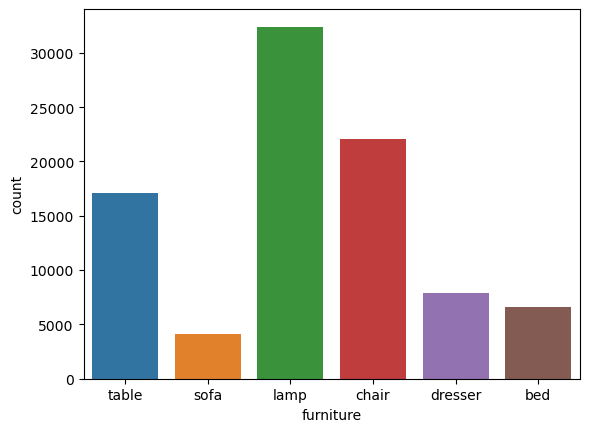

In [6]:
sns.countplot(data=df, x="furniture")

df['furniture'].value_counts()

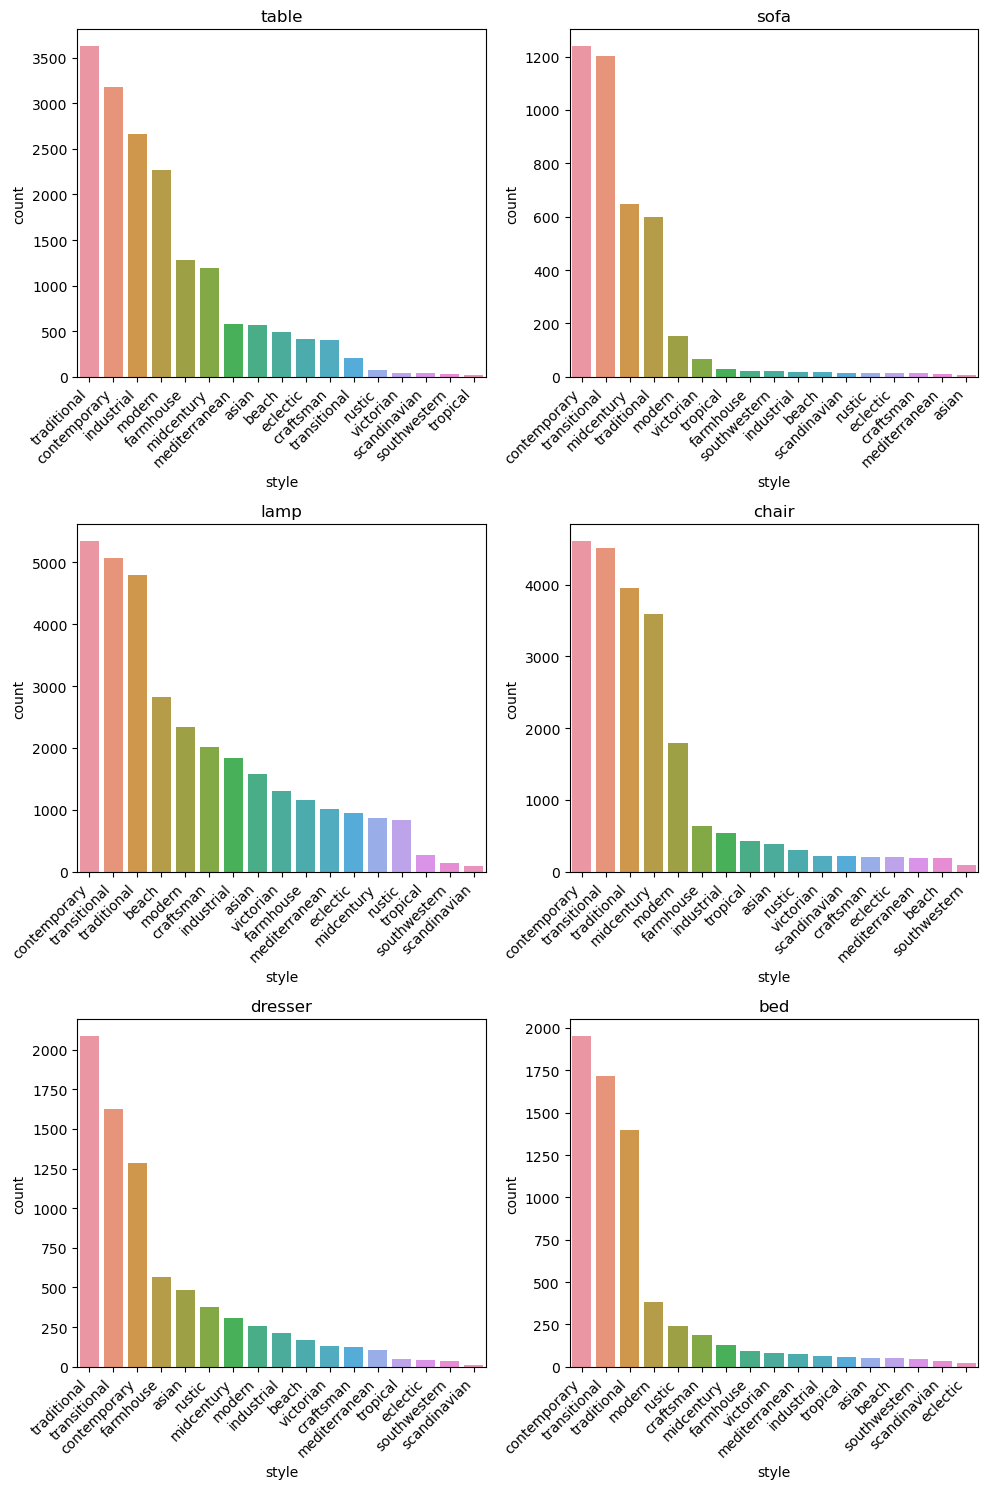

In [7]:
# Get unique furniture types
furniture_types = df['furniture'].unique()

# Create subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 15), sharex=False)

# Plot each furniture type
for i, furniture_type in enumerate(furniture_types):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    data = df[df['furniture'] == furniture_type]
    sns.countplot(x='style', data=data, order=data['style'].value_counts().index, ax=ax)
    ax.set_title(furniture_type)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

    # Show x-axis tick labels for each subplot
    ax.tick_params(axis='x', which='both', bottom=True)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

## Data Augmentation

Try to apply following data augmentation techniques 
- Flip
- Rotate
- Histogram Equalization

In [3]:
# Function for histogram equalization
def hist_equal(img):
    img_to_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    img_to_yuv[:, :, 0] = cv2.equalizeHist(img_to_yuv[:, :, 0])
    hist_equalization_result = cv2.cvtColor(img_to_yuv, cv2.COLOR_YUV2BGR)
    return hist_equalization_result

# Function for image zooming
def zoom_image(image, scale, center):
    
    height, width = image.shape[:2]
    new_height = int(height * scale)
    new_width = int(width * scale)

    zoomed_image = cv2.resize(image, (new_width, new_height))
    x = int(center[0] - width / 2)
    y = int(center[1] - width / 2)
    roi = zoomed_image[y : y + height, x : x + width]

    return roi

# # Function for image augmentation
# def image_augmentation(image):
#     flip_h = cv2.flip(image, 0) # Flip image horizontally

#     # Get image dimensions
#     height, width = flip_h.shape[:2]

#     # Define the zoom factor (e.g., zooming in by a factor of 1.5)
#     zoom_factor = 1.5

#     # Calculate the new dimensions after zooming
#     new_height = int(height * zoom_factor)
#     new_width = int(width * zoom_factor)

#     zoomed_image = cv2.resize(image, (new_width, new_height))
#     histogram = hist_equal(image)
#     adjusted = cv2.convertScaleAbs(histogram, alpha = 1.0, beta = 5) # Adjust image's contrast and brightness

#     return adjusted


# Function for image augmentation
def augment_image(image):
    transform = A.Compose([
    A.CLAHE(),
    A.RandomRotate90(),
    A.Transpose(),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50, rotate_limit=45, p=.75),
    A.Blur(blur_limit=3),
    A.OpticalDistortion(),
    A.GridDistortion(),
    A.HueSaturationValue(),
])
    augmented_image = transform(image=image)['image']
    return augmented_image

**Resampling Problem Brainstorming**
- Flowers: Only have 1 layer of category. Can easily resample by just calculating the difference between each category with the category max amount
   - Technique: Transform the curr scanned image until the current number of category matches the maximum amount
- Furniture: Have 2 layers of categories
  - Naive resampling: Can evenly distribute across furnitures, however styles distribution can be uneven 
  - More cater resampling techniques (Proposed)
    0. Copy curr image folders to `Transformed-Furnitures`
    1. Get the amount of the style of the furniture with maximum amount. Assign to `maximum_amount`
    2. (Optional) Remove that style of the furniture if's smaller than <threshold> (suggest 5% compared to max amount)
    3. Loop thru each image of the category and apply the transformation.
      3a. Increment the `current_amount` by 1
      3b. Saved the new image to corresponding category in `Transformed Furnitures`
    5. Break if `current_amount` doesn't match `maximum_amount`
    6. Continue until end of the loop. If the `current_amount` still doesn't match the `maximum_amount`, then repeat step 3,4 and 5.

### Copy raw images dir to transformed images dir

In [5]:
raw_furniture_path = './Furniture_Data'
transformed_furniture_path = './Transfomed_Furniture_Data'

In [6]:
def copy_images_dir():
    # Terminal commands to remove the 'transformed-images' folder if it exists
    if not os.path.exists(transformed_furniture_path):        
        # Terminal command to copy images to the 'transformed-images' folder
        copy_command = f"cp -r {raw_furniture_path} {transformed_furniture_path}"
        os.system(copy_command)
        print("Copying completed successfully.")
        copy_images_dir()
    else:
        print("Folder already exist")

copy_images_dir()

Folder already exist


### Calculate Furniture Style's maximum amount

In [7]:
max_amount = df.groupby(['furniture', 'style']).size().max()
max_amount


5343

### Get combinations of furniture and style unique values 


In [8]:
category_combinations = df[['furniture', 'style']].drop_duplicates().to_records(index=False)
category_combinations[:5]

rec.array([('table', 'eclectic'), ('table', 'midcentury'),
           ('table', 'craftsman'), ('table', 'victorian'),
           ('table', 'transitional')],
          dtype=[('furniture', 'O'), ('style', 'O')])

### Transform

In [16]:
def clear_transformed_images():
    # Clear images with pattern "resized" or "augmented"
    removed_augmented_command = "find . -type f -name '*-augmented*.jpg' -exec rm {} +"
    removed_resized_command = "find . -type f -name '*-resized*.jpg' -exec rm {} +"
    os.system(removed_augmented_command)
    os.system(removed_resized_command)
    print("Removed all transformed images with suffix -resized and -augmented")

def resize_image(df_category: pd.DataFrame) -> int:
    """
    Args:
    - df_category(pd.Dataframe)
    Return:
    - pd.Dataframe: New dataframe with initial images and resized images
    """
    # df_resized = df_category.copy(deep=True)
    resized_data = []
    
    for _, record in df_category.iterrows():
        # Read Image
        img_arr = cv2.imread(record['path'])
        
        # Resize
        resized_img_arr = cv2.resize(img_arr, (150, 150))
        
        # Generate a name: {current_name}-resized
        file_path, _ = os.path.splitext(record['path'])
        file_path = file_path.replace(raw_furniture_path, transformed_furniture_path)
        
        resized_path = f"{file_path}-resized.jpg"
        
        # Write output  and get path
        # print(f'Write resized image to disk {resized_path}')
        cv2.imwrite(resized_path, resized_img_arr)
        
        # Append new record to list
        resized_data.append((
            resized_path,
            record['furniture'],
            record['style']
        ))
    
    
    df_resized = pd.DataFrame(resized_data, columns=df_category.columns)
    return pd.concat([df_category, df_resized], ignore_index=True)

def advanced_transform(df_transform):
    current_amount = len(df_transform)
    augmented_data = []
    
    while current_amount < max_amount:
        # Pick random img file
        random_df_index = random.choice(df_transform.index.to_list())
        random_df_record = df_transform.iloc[random_df_index]
        
        random_img_file_path = random_df_record['path'] 
        
        #  Augment the img 
        random_img_arr = cv2.imread(random_img_file_path)
        augmented_img_arr = augment_image(random_img_arr)


        # Gen file path
        file_path, _ = os.path.splitext(random_img_file_path)
        augmented_img_file_path = f"{file_path}-augmented-{current_amount}.jpg"

        # Write augmented image to disk
        # print(f'Write augmeted image to disk {augmented_img_file_path}')
        cv2.imwrite(augmented_img_file_path, augmented_img_arr)
        
        # Store new data
        augmented_data.append((
            augmented_img_file_path,
            random_df_record['furniture'],
            random_df_record['style']
        ))
        
        current_amount += 1 

    
    df_augmented = pd.DataFrame(augmented_data, columns=df_transform.columns)
    return pd.concat([df_transform, df_augmented], ignore_index=True)
        
        
def transform(df: pd.DataFrame) -> pd.DataFrame:
    # Removed old transformed images before executing new ones
    clear_transformed_images()
    
    df_transform = None
    for furniture, style in tqdm(category_combinations):
        print(furniture, style)
        df_category = df[(df['furniture'] == furniture) & (df['style'] == style)]

        # Resize  first
        df_resized =  resize_image(df_category)
        
        df_transform = df_resized if df_transform is None else pd.concat([df_transform, df_resized], ignore_index=True)
        
        # Random pick an image in transformed image, then perform aumgnetation
        df_transform = advanced_transform(df_transform)

    
    return df_transform


dummy = transform(df)

Removed all transformed images with suffix -resized and -augmented


  0%|                                                                                                                                                                                                                                | 0/102 [00:00<?, ?it/s]

table eclectic


  1%|██                                                                                                                                                                                                                      | 1/102 [00:20<35:04, 20.83s/it]

table midcentury


  2%|████▏                                                                                                                                                                                                                   | 2/102 [00:23<16:40, 10.00s/it]

table craftsman


  4%|████████▍                                                                                                                                                                                                               | 4/102 [00:24<05:52,  3.60s/it]

table victorian
table transitional


  5%|██████████▌                                                                                                                                                                                                             | 5/102 [00:24<03:59,  2.46s/it]

table mediterranean


  6%|████████████▋                                                                                                                                                                                                           | 6/102 [00:26<03:17,  2.06s/it]

table traditional


  7%|██████████████▊                                                                                                                                                                                                         | 7/102 [00:33<06:07,  3.87s/it]

table industrial


  8%|████████████████▉                                                                                                                                                                                                       | 8/102 [00:39<06:52,  4.39s/it]

table farmhouse


 11%|███████████████████████▏                                                                                                                                                                                               | 11/102 [00:41<03:07,  2.06s/it]

table tropical
table southwestern
table beach


 12%|█████████████████████████▎                                                                                                                                                                                             | 12/102 [00:42<02:42,  1.81s/it]

table modern


 13%|███████████████████████████▍                                                                                                                                                                                           | 13/102 [00:47<03:38,  2.46s/it]

table contemporary


 15%|███████████████████████████████▌                                                                                                                                                                                       | 15/102 [00:53<03:42,  2.56s/it]

table rustic
table scandinavian
table asian


 17%|███████████████████████████████████▊                                                                                                                                                                                   | 17/102 [00:54<02:24,  1.70s/it]

sofa eclectic
sofa midcentury


 21%|████████████████████████████████████████████▎                                                                                                                                                                          | 21/102 [00:56<01:11,  1.14it/s]

sofa craftsman
sofa victorian
sofa transitional


 22%|██████████████████████████████████████████████▎                                                                                                                                                                        | 22/102 [00:59<01:38,  1.23s/it]

sofa mediterranean
sofa traditional


 25%|██████████████████████████████████████████████████████▊                                                                                                                                                                | 26/102 [01:00<00:52,  1.44it/s]

sofa industrial
sofa farmhouse
sofa tropical
sofa southwestern


 27%|███████████████████████████████████████████████████████████                                                                                                                                                            | 28/102 [01:00<00:36,  2.05it/s]

sofa beach
sofa modern


 29%|███████████████████████████████████████████████████████████████▏                                                                                                                                                       | 30/102 [01:01<00:28,  2.54it/s]

sofa contemporary


 33%|███████████████████████████████████████████████████████████████████████▋                                                                                                                                               | 34/102 [01:03<00:31,  2.18it/s]

sofa rustic
sofa scandinavian
sofa asian
lamp eclectic
lamp midcentury


 35%|███████████████████████████████████████████████████████████████████████████▉                                                                                                                                           | 36/102 [01:07<00:54,  1.20it/s]

lamp craftsman


 36%|█████████████████████████████████████████████████████████████████████████████▉                                                                                                                                         | 37/102 [01:11<01:30,  1.40s/it]

lamp victorian


 37%|████████████████████████████████████████████████████████████████████████████████                                                                                                                                       | 38/102 [01:13<01:45,  1.65s/it]

lamp transitional


 38%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                    | 39/102 [01:23<03:33,  3.38s/it]

lamp mediterranean


 39%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                  | 40/102 [01:25<03:10,  3.07s/it]

lamp traditional


 40%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                | 41/102 [01:34<04:45,  4.68s/it]

lamp industrial


 41%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 42/102 [01:38<04:20,  4.35s/it]

lamp farmhouse


 42%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                            | 43/102 [01:40<03:43,  3.78s/it]

lamp tropical


 43%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 44/102 [01:41<02:46,  2.87s/it]

lamp southwestern


 44%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                        | 45/102 [01:41<02:01,  2.13s/it]

lamp beach


 45%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                      | 46/102 [01:47<02:55,  3.13s/it]

lamp modern


 46%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                    | 47/102 [01:51<03:09,  3.44s/it]

lamp contemporary


 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                 | 48/102 [02:01<04:48,  5.33s/it]

lamp rustic


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                             | 50/102 [02:02<02:37,  3.03s/it]

lamp scandinavian
lamp asian


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 51/102 [02:05<02:34,  3.03s/it]

chair eclectic


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                         | 52/102 [02:06<01:53,  2.26s/it]

chair midcentury


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                       | 53/102 [02:13<02:59,  3.67s/it]

chair craftsman


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                     | 54/102 [02:13<02:09,  2.70s/it]

chair victorian


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 55/102 [02:14<01:35,  2.04s/it]

chair transitional


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 56/102 [02:23<03:12,  4.18s/it]

chair mediterranean


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 57/102 [02:23<02:17,  3.05s/it]

chair traditional


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 58/102 [02:32<03:25,  4.68s/it]

chair industrial


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 59/102 [02:33<02:35,  3.62s/it]

chair farmhouse


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 60/102 [02:34<02:03,  2.94s/it]

chair tropical


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 61/102 [02:35<01:36,  2.35s/it]

chair southwestern


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 62/102 [02:36<01:08,  1.72s/it]

chair beach


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 63/102 [02:36<00:51,  1.33s/it]

chair modern


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 64/102 [02:40<01:17,  2.04s/it]

chair contemporary


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 65/102 [02:49<02:35,  4.19s/it]

chair rustic


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 66/102 [02:50<01:53,  3.14s/it]

chair scandinavian


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 67/102 [02:50<01:21,  2.33s/it]

chair asian


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 69/102 [02:51<00:44,  1.36s/it]

dresser eclectic
dresser midcentury


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 70/102 [02:52<00:36,  1.15s/it]

dresser craftsman


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 71/102 [02:52<00:27,  1.11it/s]

dresser victorian


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 72/102 [02:52<00:22,  1.34it/s]

dresser transitional


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 73/102 [02:56<00:45,  1.58s/it]

dresser mediterranean


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 74/102 [02:56<00:33,  1.20s/it]

dresser traditional


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 75/102 [03:01<01:02,  2.30s/it]

dresser industrial


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 76/102 [03:02<00:45,  1.76s/it]

dresser farmhouse


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 78/102 [03:03<00:28,  1.19s/it]

dresser tropical
dresser southwestern


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 79/102 [03:03<00:19,  1.16it/s]

dresser beach


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 80/102 [03:04<00:15,  1.38it/s]

dresser modern


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 81/102 [03:04<00:14,  1.49it/s]

dresser contemporary


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 82/102 [03:07<00:25,  1.29s/it]

dresser rustic


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 83/102 [03:08<00:22,  1.17s/it]

dresser scandinavian
dresser asian


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 85/102 [03:09<00:15,  1.10it/s]

bed eclectic
bed midcentury


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 87/102 [03:09<00:08,  1.68it/s]

bed craftsman


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 89/102 [03:10<00:05,  2.29it/s]

bed victorian
bed transitional


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 91/102 [03:12<00:08,  1.34it/s]

bed mediterranean
bed traditional


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 93/102 [03:15<00:07,  1.16it/s]

bed industrial
bed farmhouse


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 95/102 [03:15<00:03,  2.01it/s]

bed tropical
bed southwestern
bed beach


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 97/102 [03:15<00:01,  3.19it/s]

bed modern


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 98/102 [03:16<00:01,  2.68it/s]

bed contemporary


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 99/102 [03:18<00:03,  1.01s/it]

bed rustic


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 102/102 [03:19<00:00,  1.96s/it]

bed scandinavian
bed asian


In [17]:
dummy.furniture.value_counts()

furniture
lamp       64802
chair      44106
table      38723
dresser    15740
bed        13156
sofa        8160
Name: count, dtype: int64

In [18]:
dummy.shape

(184687, 3)